In [1]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import simpy

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.trajectories import time_step as ts
from tf_agents.specs import tensor_spec
#from env.RideSimulator.Grid import Grid
import tf_agents


import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from RideSimulator.taxi_sim import run_simulation

In [2]:
#register custom env
import gym

gym.envs.register(
     id='taxi-v0',
     entry_point='env.taxi:TaxiEnv',
     max_episode_steps=1500,
     kwargs={'state_dict':None},
)

In [82]:
#hyper params

num_iterations = 20 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 10  # @param {type:"integer"}

num_eval_episodes = 5  # @param {type:"integer"}
eval_interval = 5  # @param {type:"integer"}action

In [83]:
#load taxi env
env_name = "taxi-v0"
env = suite_gym.load(env_name)

tf_env = tf_py_environment.TFPyEnvironment(env)
reset = tf_env.reset()


In [84]:
#agent and policy
fc_layer_params = (100,)


q_net = q_network.QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()


#random policy
random_policy = random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(),tf_env.action_spec())

#agent policy
eval_policy = agent.policy
collect_policy = agent.collect_policy

eval_policy_list = [eval_policy]
collect_policy_list = [collect_policy]

#replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)
    
replay_buffer_list = [replay_buffer]

In [85]:
#create dataset and iterator
# Dataset generates trajectories with shape [Bx2x...]
dataset_list = []
iterator_list = []

for replay_buffer in replay_buffer_list:
    dataset = replay_buffer.as_dataset(
        num_parallel_calls=3, 
        sample_batch_size=batch_size, 
        num_steps=2).prefetch(3)
    dataset_list.append(dataset)

    iterator = iter(dataset)
    iterator_list.append(iterator)
    
    print(iterator)

In [86]:
"""
policy.action(reset)
#tf_env.time_step_spec()
print(reset)
#print(env.reset())
#print(ts.restart(tf.convert_to_tensor(np.array([0,0,0,0], dtype=np.int32), dtype=tf.float32)))
print(" ")
print(ts.TimeStep(tf.constant([0]), tf.constant([0.0]), tf.constant([1.0]),tf.convert_to_tensor(np.array([[0,0,0,0]], dtype=np.int32), dtype=tf.float32)))

#print(tensor_spec.to_array_spec(reset))
#encoder_func = tf_agents.utils.example_encoding.get_example_encoder(env.reset())
#encoder_func(env.reset())
"""

#run_simulation(policy)
#ts.termination(np.array([1,2,3,4], dtype=np.int32), reward=0.0)
#ts.transition(np.array([1,2,3,4], dtype=np.int32), reward=0.0, discount=1.0)

'\npolicy.action(reset)\n#tf_env.time_step_spec()\nprint(reset)\n#print(env.reset())\n#print(ts.restart(tf.convert_to_tensor(np.array([0,0,0,0], dtype=np.int32), dtype=tf.float32)))\nprint(" ")\nprint(ts.TimeStep(tf.constant([0]), tf.constant([0.0]), tf.constant([1.0]),tf.convert_to_tensor(np.array([[0,0,0,0]], dtype=np.int32), dtype=tf.float32)))\n\n#print(tensor_spec.to_array_spec(reset))\n#encoder_func = tf_agents.utils.example_encoding.get_example_encoder(env.reset())\n#encoder_func(env.reset())\n'

In [87]:
#create a static environment for evaluation purposes

#policy that always accepts
class AcceptPolicy:
  def __init__(self):
    print("init")

  def action(self, obs):
    return (tf.constant([1]))

acceptPol = AcceptPolicy()

eval_env = run_simulation([acceptPol])
#print(eval_env)

init
Number of trips generated: 2237


In [88]:
#evaluate a trained policy with respect to a pre-generated static environment
def evaluatePolicy(policy, eval_env):
    episode_reward = 0
    for state_list in eval_env:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf)
            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
            else:
                reward = 0
            print (reward)
            driver_reward += reward
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)

#evaluatePolicy(acceptPol, eval_env)

In [89]:
# compute average return
def compute_avg_return(policy_list, num_episodes=10):
    total_rewards = defaultdict(int)
    avg_returns = defaultdict(int)

    for i in range (num_episodes):
        #run one episode of simulation and record states
        episode_rewards = defaultdict(int)
        policy_state_lists_dict = run_simulation(policy_list)
        for policy, state_lists in policy_state_lists_dict.items():
            for state_list in state_lists:
                states = []
                driver_reward = 0

                #convert states directly to tf timesteps
                for i in range(len(state_list)):
                    state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    driver_reward += state_tf.reward
                episode_rewards[policy] += driver_reward
                
            #take average reward for all drivers in the episode
            episode_rewards[policy] = episode_rewards[policy] / len(state_lists)
            total_rewards[policy] += episode_rewards[policy]

    for policy in policy_state_lists_dict:
        avg_returns[policy] = total_rewards[policy] / num_episodes
        avg_returns[policy] = avg_returns[policy].numpy()
    print(avg_returns)
    return avg_returns


In [90]:
#collect trajectories

def collect_data(num_iterations, policy_list, replay_buffer_list):
    for i in range (num_iterations):
        #run one episode of simulation and record states
        policy_state_lists_dict = run_simulation(policy_list)
        for policy, state_lists in policy_state_lists_dict.items():
            print("driver count : ", len(state_lists))
            for state_list in state_lists:
                states = []
                actions = []

                #convert states directly to tf timesteps
                for i in range(len(state_list)):
                    #create time step
                    if i == 0:
                        #state_tf = ts.restart(np.array(state_list[i]["observation"], dtype=np.float32))
                        state_tf = ts.TimeStep(tf.constant([0]), tf.constant([3.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                        #print("first reward ", state_list[i]["reward"])
                        #print (state_tf)
                    elif i < (len(state_list) - 1):
                        #reward is taken fro (i-1) because it should be the reward from the already completed action (prev. action)
                        state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                        #state_tf = ts.termination(np.array(state_list[i]["observation"], dtype=np.float32), reward=state_list[i]["reward"])
                    else:
                        state_tf = ts.TimeStep(tf.constant([2]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([0.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))

                    #create action
                    """if state_list[i]["action"] == 1:
                        action = tf.constant([1], dtype=tf.int32)
                    else:
                        action = tf.constant([0], dtype=tf.int32)"""
                    action = state_list[i]["action"]

                    #print (action)
                    states.append(state_tf)
                    actions.append(action)
                    
                for j in range(len(states)-1):
                    present_state = states[j]
                    next_state = states[j+1]
                    action = actions[j]
                    traj = trajectory.from_transition(present_state, action, next_state)
                    #print(action)
                    # Add trajectory to the replay buffer
                    replay_buffer_list[policy].add_batch(traj)
                    #print(traj)
    

        """
        #re-register environemnt with new states
        env_name = 'taxi-v'+str(i)
        gym.envs.register(
             id=env_name,
             entry_point='env.taxi:TaxiEnv',
             max_episode_steps=1500,
             kwargs={'state_dict':state_list},
        )

        #reload new env
        env = suite_gym.load(env_name)
        tf_env = tf_py_environment.TFPyEnvironment(env)

        #reset tf env
        time_step = tf_env.reset()

        #loop through recorded steps
        for step in state_dict:
            present_state = tf_env.current_time_step()
            action = step.action
            new_state = tf_env.step(action)
            traj = trajectory.from_transition(time_step, action_step, next_time_step)
            replay_buffer.add_batch(traj)
        """
        #print(replay_buffer)
#collect_data(num_iterations, policy, replay_buffer)

In [91]:
#train agents

try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_returns = compute_avg_return(eval_policy_list, num_eval_episodes)
returns = [avg_returns]
lost_iterations = 0
for _ in range(num_iterations):
    try:
        # Collect a few steps using collect_policy and save to the replay buffer.
        collect_data(collect_steps_per_iteration, collect_policy_list, replay_buffer_list)
        
        # Sample a batch of data from the buffer and update the agent's network.
        
        train_loss_list = []
        for iterator in iterator_list:
            experience, unused_info = next(iterator)
            train_loss = agent.train(experience).loss
            train_loss_list.append(train_loss)

        step = agent.train_step_counter.numpy()

        if step % log_interval == 0:
            print('step = {0}: loss = {1}'.format(step, train_loss_list))

        if step % eval_interval == 0:
            avg_returns = compute_avg_return(eval_policy_list, num_eval_episodes)
            print('step = {0}: Average Return = {1}'.format(step, avg_returns))
            returns.append(avg_return)
            print("evaluation")
    
    except IndexError:
        lost_iterations += 1
        print("skipping iteration due to driver error")

Number of trips generated: 2210
Number of trips generated: 2315
Number of trips generated: 2239
Number of trips generated: 2157
Number of trips generated: 2161
defaultdict(<class 'int'>, {0: 41304.56})
Number of trips generated: 2291
driver count :  20
Number of trips generated: 2208
driver count :  20
Number of trips generated: 2217
driver count :  20
Number of trips generated: 2204
driver count :  20
Number of trips generated: 2212
driver count :  20
Number of trips generated: 2307
Number of trips generated: 2252
Number of trips generated: 2247
Number of trips generated: 2209
Number of trips generated: 2186
defaultdict(<class 'int'>, {0: 43339.363})
step = 5: Average Return = defaultdict(<class 'int'>, {0: 43339.363})
evaluation
Number of trips generated: 2145
driver count :  20
Number of trips generated: 2149
driver count :  20
Number of trips generated: 2137
driver count :  20
Number of trips generated: 2203
driver count :  20
Number of trips generated: 2160
driver count :  20
step

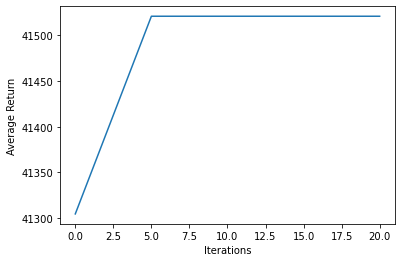

In [92]:
#visualize progress
for i in range(len(collect_policy_list)):
    per_policy_returns = []
    for avg_returns_dict in returns:
        per_policy_returns.append(avg_returns_dict[i])

    iterations = range(0, num_iterations +1, eval_interval)
    plt.plot(iterations, per_policy_returns)
    plt.ylabel('Average Return')
    plt.xlabel('Iterations')
#plt.ylim(top=50000)

In [ ]:
#run_simulation(eval_policy)
evaluatePolicy(acceptPol, eval_env)

In [73]:
"""
reward results - 
random policy - around 9.5k
learned policy - 14k
always accept policy - 19.4k
"""






In [ ]:
a = 55.4
print(a.numpy())

In [ ]:
# startup simulation

def simpy_episode(rewards, steps, time_step, tf_env, policy):

    TIME_MULTIPLIER = 50
    DRIVER_COUNT = 1
    TRIP_COUNT = 8000
    RUN_TIME = 10000
    INTERVAL = 20
    # GRID_WIDTH = 3809
    # GRID_HEIGHT = 2622
    GRID_WIDTH = 60
    GRID_HEIGHT = 40
    HEX_AREA = 2.6

    Env = simpy.Environment()
    map_grid = Grid(env=Env, width=GRID_WIDTH, height=GRID_HEIGHT, interval=INTERVAL, num_drivers=DRIVER_COUNT,
                    hex_area=HEX_AREA)

    taxi_spots = map_grid.taxi_spots
    driver_list = create_drivers(Env, DRIVER_COUNT, map_grid)
    driver_pools = map_grid.driver_pools

    run_simulation(TRIP_COUNT, RUN_TIME, DRIVER_COUNT, TIME_MULTIPLIER, map_grid, taxi_spots, driver_list, driver_pools, Env, rewards, steps, time_step, tf_env, policy)
    t_count = 0
    for dr in driver_list:
        d_t_count = dr.total_trip_count
        t_count += d_t_count
        print(f"{dr.id} completed {d_t_count}")

    print(f"Total trip count: {t_count}")

In [ ]:
var = tf.random.uniform([1], 0, 2, dtype=tf.int32)
var[0] = 2
print (var)

In [ ]:
#simple episode run - atttempt 1

time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
    simpy_episode(rewards, step, time_step, tf_env, policy)

    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

In [ ]:
#simple episode run - atttempt 2

#time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
    time_step = tf_env.reset()
    
    
    
    
    
    
    simpy_episode(rewards, step, time_step, tf_env, policy)

    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

In [ ]:
#simple episode run template
"""
time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
  episode_reward = 0
  episode_steps = 0
  while not time_step.is_last():
    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

print('num_episodes:', num_episodes, 'num_steps:', num_steps)
print('avg_length', avg_length, 'avg_reward:', avg_reward)
"""